# Trans-Effects 

Here we look for genes NOT in the event discussed that are affected by the arm-level event. We will find these effects by performing a series of t-tests comparing the proteomic values of the patients with the event against those without the event.

## Setup (Install necessary packages)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from utils import *

cptac warning: Your version of cptac (0.8.1) is out-of-date. Latest is 0.8.2. Please run 'pip install --upgrade cptac' to update it. (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 5)


In [2]:
# Load in the data for the cancer types that have
# the event you want to look at.
luad = cptac.Luad()
hnscc = cptac.Hnscc()
ovarian = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
lscc = cptac.Lscc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 4)


version 3scc v3.2.......                    


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 8)


In [27]:
# Now we need to get the proteomics tables for each
# type of cancer
proteomics = {
    'luad': luad.get_proteomics(),
    'hnscc': hnscc.get_proteomics(),
    'ovarian': ovarian.get_proteomics(),
    'colon': colon.get_proteomics(),
    'brca': brca.get_proteomics(),
    'lscc': lscc.get_proteomics()
}

## Append gene locations

In [28]:
locations = get_gene_locations()

In [29]:
# This will append the location data to each table
# in your proteomics dictionary
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df.transpose()
    if not isinstance(df.index, pd.MultiIndex):
        new_df = df.join(locations.droplevel(1))
        new_df.drop_duplicates(inplace=True)
        proteomics[cancer_type] = new_df.dropna()
    else:
        new_df = df.join(locations)
        new_df.drop_duplicates(inplace=True)
        proteomics[cancer_type] = new_df.dropna()

## Remove proteins in event

Before running our t-tests, we need to remove all the proteins that are in the event we are looking at (we only want to look at TRANS effects)

In [30]:
# Place here which chromosome and arm you want to look at
# the chromosome number should be a string, 
# the arm should be either p or q (lower case)
CHROMOSOME = '8'
ARM = 'q'

In [31]:
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df[(df.arm != ARM) | (df.chromosome != CHROMOSOME)]
    df.drop(['chromosome', 'start_bp', 'end_bp', 'arm'], axis=1, inplace=True)
    proteomics[cancer_type] = df

C:\Users\chels\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Append Event Data

We now need to append the data from the event table that should have been created in a previous notebook.

In [32]:
# set this variable to the column that represents the event we are looking at
EVENT_COLUMN = 'gain_event'

In [33]:
has_event = dict()
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df.transpose()
    # You may need to edit the path to the table with the event information. 
    event = pd.read_csv(f'{cancer_type}_has_event.tsv', sep='\t', index_col=0)
    event.index.rename('Name')
    df = df.join(event)
    df = df.dropna(subset=[EVENT_COLUMN])
    has_event[cancer_type] = df[EVENT_COLUMN]
    proteomics[cancer_type] = df

C:\Users\chels\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [36]:
import cptac.utils as ut

In [38]:
luad_prot = proteomics['luad'].copy()
luad_prot.drop('gain_event', axis=1, inplace=True)
ut.wrap_ttest(luad_prot, label_column='loss_event', return_all=True)

,Comparison,P_Value
0,"(CHMP7, NP_689485.1|NP_001350112.1|NP_00130482...",1.777490e-11
1,"(VPS37A, NP_001350102.1|NP_001350096.1|NP_0011...",2.030119e-11
2,"(CCAR2, NP_066997.3)",1.805337e-10
3,"(PPP2R2A, NP_002708.1|NP_001171062.1)",2.399685e-10
4,"(MSRA, NP_036463.1|NP_001129143.1|NP_001186658...",2.748674e-10
...,...,...
6829,"(URI1, NP_003787.2|NP_001239570.1)",9.986303e-01
6830,"(ANOS1, NP_000207.2)",9.988259e-01
6831,"(RBP1, NP_002890.2|NP_001124464.1|NP_001124465.1)",9.988656e-01
6832,"(NENF, NP_037481.1)",9.989554e-01


## Run T-Tests

In [10]:
def t_test(col, event):
    has_event = col[event]
    invert_list = [not x for x in event]
    no_event = col[invert_list]
    event_avg = has_event.mean()
    no_event_avg = no_event.mean()
    stat, pvalue = stats.ttest_ind(has_event, no_event)
    return(event_avg - no_event_avg, pvalue)

In [11]:
# Enter all the columns from the event dataframe that represent 
# events. If there is only one event column in the dataframe, you 
# can set this variable to be EVENT_COLUMNS
EVENT_COLUMNS_TO_DROP = ['gain_event', 'loss_event']

In [12]:
results_df = None
for cancer_type in proteomics.keys():
    prot_df = proteomics[cancer_type].drop(EVENT_COLUMNS_TO_DROP, axis=1)
    results = prot_df.apply(lambda x: t_test(x, has_event[cancer_type]))
    df = pd.DataFrame(results)
    if isinstance(df.index[0], tuple):
        df[['Name', f'{cancer_type}_Database_ID']] = pd.DataFrame(df.index.values.tolist(), index=df.index)
        df.set_index(['Name', f'{cancer_type}_Database_ID'], inplace=True)
    else:
        df.index.name='Name'
    if isinstance(df[0][0], tuple):
        df[[f'{cancer_type}_avg', f'{cancer_type}_pvalue']] = pd.DataFrame(df[0].tolist(), index=df.index)
        df.drop([0], axis=1, inplace=True)
    if results_df is None:
        results_df = df
    else:
        results_df = results_df.join(df)

In [13]:
# This will save the resulting table in the same directory as this notebook.
# Modify if you would like to save to a different location.
results_df.to_csv(f"{CHROMOSOME}{ARM}_transeffects.tsv", sep='\t')

## Make Volcano Plot

We now want to visualize our results. We will use a volcano plot to do this.

In [17]:
# Get pvalue columns
pvalues_cols = [x for x in list(results_df.columns) if x.endswith('pvalue')]
# Log transform each pvalue column
for col in pvalues_cols:
    results_df[f'{col}_log'] = results_df[col].apply(lambda x: -np.log10(x))

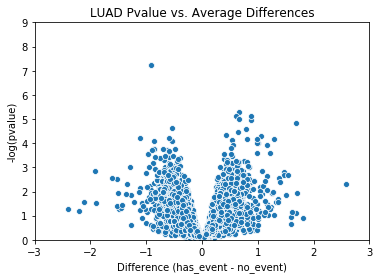

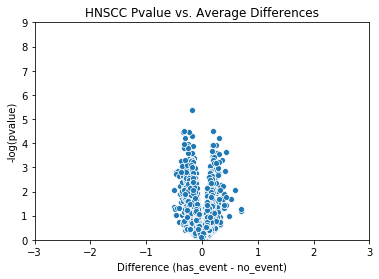

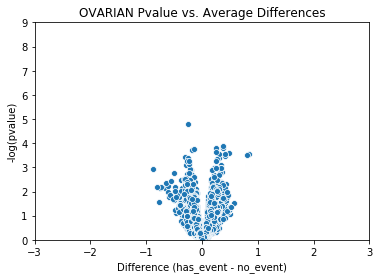

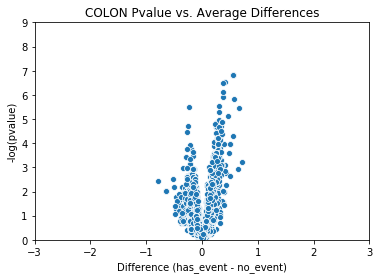

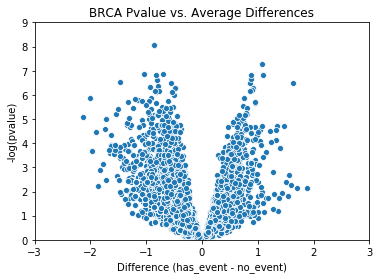

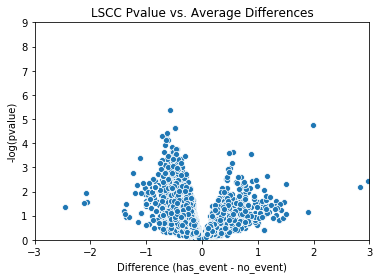

In [20]:
for cancer_type in proteomics.keys():
    plt.figure()
    sns.scatterplot(x=f'{cancer_type}_avg', y=f'{cancer_type}_pvalue_log', data=results_df)
    # You will want to change the xlim and ylim to best fit your data.
    # We set them for each figure so that each graph is comparable to the others.
    plt.xlim(-3, 3)
    plt.ylim(0,9)
    plt.xlabel("Difference (has_event - no_event)")
    plt.ylabel("-log(pvalue)")
    plt.title(f'{cancer_type.upper()} Pvalue vs. Average Differences')
    plt.show()

## Explore

Next we want to understand what our results mean. There are many ways you may find  significant proteins and patterns to look at. Some examples of what you might do include:

 * Print the rows where all cancer types have a significant pvalue
 * Print the rows where a given portion of the cancer types have a significant pvalue
 * Find the proteins that appear in the top left and right corners of the volcano plots. Where do these proteins fall on other graphs? Learn a litte about these 

In [21]:
results_df

,,,,,luad_avg,luad_pvalue,hnscc_avg,hnscc_pvalue,ovarian_avg,ovarian_pvalue,colon_avg,colon_pvalue,brca_avg,brca_pvalue,lscc_avg,lscc_pvalue,luad_pvalue_log,hnscc_pvalue_log,ovarian_pvalue_log,colon_pvalue_log,brca_pvalue_log,lscc_pvalue_log
Name,brca_Database_ID,luad_Database_ID,ovarian_Database_ID,lscc_Database_ID,,,,,,,,,,,,,,,,,,
A1BG,NP_570602.2,NP_570602.2,NP_570602,NP_570602.2,0.018228,0.933583,-0.075722,0.253556,-0.096252,0.519230,-0.363979,0.014376,-0.604953,0.015350,0.147324,0.483371,0.029847,0.595925,0.284640,1.842375,1.813888,0.315719
A2M,NP_000005.2,NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR8|K4JBA2|K4JB97,NP_000005,NP_000005.2|NP_001334353.1|NP_001334354.1,0.181837,0.526662,-0.073016,0.491629,0.022644,0.903679,-0.153202,0.217211,-0.010696,0.970885,-0.139115,0.642515,0.278468,0.308362,0.043986,0.663119,0.012832,0.192117
AAAS,NP_056480.1|NP_001166937.1,NP_056480.1|NP_001166937.1,NP_056480,NP_056480.1|NP_001166937.1,0.208068,0.062692,0.020537,0.616417,0.045529,0.383688,0.089587,0.257142,0.182912,0.086419,-0.075273,0.437029,1.202788,0.210126,0.416022,0.589827,1.063389,0.359490
AACS,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417,NP_076417.2|NP_001306769.1|NP_001306768.1,0.326426,0.314904,0.088849,0.319777,-0.068586,0.573257,0.022990,0.761555,-0.601837,0.045548,-0.092006,0.757058,0.501821,0.495152,0.241651,0.118299,1.341535,0.120871
AAGAB,NP_078942.3|NP_001258815.1,NP_078942.3|NP_001258814.1,NP_078942,NP_078942.3|NP_001258814.1,-0.020575,0.895371,0.034488,0.612485,-0.064130,0.430410,-0.144167,0.058421,-0.409365,0.018323,-0.091437,0.568422,0.047997,0.212904,0.366118,1.233433,1.736997,0.245329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN18,NP_001139014.1|NP_001139015.1,NP_001139014.1|NP_001139015.1|NP_001139016.1,NaN,NP_001139014.1|NP_001139015.1|NP_001139016.1,0.450257,0.038190,NaN,NaN,NaN,NaN,NaN,NaN,-0.824847,0.000613,-0.367297,0.113874,1.418047,NaN,NaN,NaN,3.212587,0.943576
ZW10,NP_004715.1,NP_004715.1,NP_004715,NP_004715.1,0.075075,0.578185,0.021921,0.507186,-0.070333,0.130762,0.022748,0.583077,-0.066283,0.556495,-0.117721,0.225467,0.237933,0.294833,0.883520,0.234274,0.254539,0.646918
ZYG11B,NP_078922.1,NP_078922.1,NP_078922,NP_078922.1,0.189715,0.099858,-0.012633,0.783443,-0.042698,0.485714,NaN,NaN,0.148533,0.190291,-0.137114,0.237700,1.000617,0.105992,0.313619,NaN,0.720582,0.623972
